In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from primeGraph.models import GraphState
from primeGraph.buffer import History
from primeGraph import Graph, START, END
from primeGraph.graph.engine import GraphExecutor
import time

from rich import print as rprint

import logging

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

class StateForTestWithHistory(GraphState):
    execution_order: History[str]


def test_graph(storage=None):
    state = StateForTestWithHistory(execution_order=[])
    graph = Graph(state=state, checkpoint_storage=storage)

    @graph.node()
    def task1(state):
        time.sleep(1)
        print("task1")
        return {"execution_order": "task1"}

    @graph.node(interrupt="after")
    def task2(state):
        time.sleep(2)
        print("task2")
        return {"execution_order": "task2"}

    @graph.node()
    def task3(state):
        time.sleep(2)
        print("task3")
        return {"execution_order": "task3"}

    @graph.node()
    def task4(state):
        time.sleep(1)
        print("task4")
        return {"execution_order": "task4"}
    
    @graph.node()
    def task5(state):
        time.sleep(1)
        print("task5")
        return {"execution_order": "task5"}
    
    @graph.node()
    def task6(state):
        time.sleep(1)
        print("task6")
        return {"execution_order": "task6"}

    # Create parallel paths
    graph.add_edge(START, "task1")
    graph.add_edge("task1", "task2")
    graph.add_edge("task1", "task3")
    graph.add_edge("task2", "task4")
    graph.add_edge("task3", "task5")
    graph.add_edge("task4", "task6")
    graph.add_edge("task5", "task6")
    graph.add_edge("task6", END)

    graph.compile()

    return graph


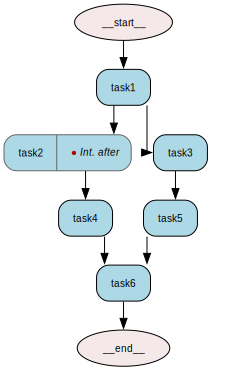

In [2]:
from primeGraph.checkpoint.local_storage import LocalStorage

graph = test_graph(storage=LocalStorage())
graph.visualize()

In [ ]:
import asyncio

# In your notebook
executor = GraphExecutor(graph)
task = asyncio.create_task(executor.execute())  # Start execution

# Wait a bit for it to hit the interrupt
await asyncio.sleep(5)  

# Then call resume to continue
# executor.resume()

In [3]:
import asyncio

# Add debug logging
logging.getLogger('primeGraph.checkpoint.local_storage').setLevel(logging.DEBUG)
logging.getLogger('primeGraph.graph.engine').setLevel(logging.DEBUG)

executor = GraphExecutor(graph)
task = asyncio.create_task(executor.execute())

# Wait a bit and print engine state before checkpoint
await asyncio.sleep(4)
print("\n=== Engine State BEFORE checkpoint ===")
rprint(executor.get_full_state())

# Print checkpoint state right after it's saved
await asyncio.sleep(0.1)  # Small delay to ensure checkpoint is saved
last_checkpoint = list(graph.checkpoint_storage._storage[list(graph.checkpoint_storage._storage.keys())[0]].keys())[-1]
checkpoint_state = graph.checkpoint_storage._storage[list(graph.checkpoint_storage._storage.keys())[0]][last_checkpoint]
print("\n=== Checkpoint State ===")
rprint(checkpoint_state.engine_state)

# Wait a bit longer for task5 to complete
await asyncio.sleep(2)
print("\n=== Engine State AFTER task5 completion ===")
rprint(executor.get_full_state())

DEBUG:primeGraph.graph.engine:Executing node '__start__' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=[]
DEBUG:primeGraph.graph.engine:Executing node 'task1' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=[]
INFO:primeGraph.checkpoint.local_storage:Checkpoint 'checkpoint_1c627909-dcb9-48e2-a28e-98fd0e36ab61' saved in memory.
DEBUG:primeGraph.graph.engine:Node 'task1' launches parallel branches: ['task2', 'task3']
DEBUG:primeGraph.graph.engine:Processing frame with branch_id 0 at node task2
DEBUG:primeGraph.graph.engine:Current active branches: {'task6': {0, 1}}
DEBUG:primeGraph.graph.engine:Executing node 'task2' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=['task1']
DEBUG:primeGraph.graph.engine:Processing frame with branch_id 1 at node task3
DEBUG:primeGraph.graph.engine:Current active branches: {'task6': {0, 1}}
DEBUG:primeGraph.graph.engine:Executing node 'task3' with state: version='a68afb7bed1b464bc9ee75f

task1


INFO:primeGraph.checkpoint.local_storage:Checkpoint 'checkpoint_7bb8025e-0555-4462-be56-4ab3cbd7fe9d' saved in memory.
DEBUG:primeGraph.graph.engine:Processing frame with branch_id 1 at node task5
DEBUG:primeGraph.graph.engine:Current active branches: {'task6': {0, 1}}
DEBUG:primeGraph.graph.engine:Executing node 'task5' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=['task1']
INFO:primeGraph.checkpoint.local_storage:Checkpoint 'checkpoint_e3424705-f7b0-481f-b37a-10c5d7a34bb2' saved in memory.
DEBUG:primeGraph.graph.engine:[Interrupt-after] Executed node 'task2'.
DEBUG:primeGraph.graph.engine:Execution paused. Waiting for resume...


task2task3


=== Engine State BEFORE checkpoint ===
task5


{
    'execution_frames': [],
    'visited_nodes': {'__start__', 'task2', 'task3', 'task1'},
    'branch_counter': 2,
    'active_branches': {'task6': {0, 1}},
    'graph_state': StateForTestWithHistory(
        version='a68afb7bed1b464bc9ee75fa7adf0b26',
        execution_order=['task1', 'task3', 'task2']
    ),
    'chain_status': 'PAUSE'
}

INFO:primeGraph.checkpoint.local_storage:Checkpoint 'checkpoint_1aa774f9-82b0-4996-b016-2b4f4d204912' saved in memory.
DEBUG:primeGraph.graph.engine:Processing frame with branch_id 1 at node task6
DEBUG:primeGraph.graph.engine:Current active branches: {'task6': {0}}
DEBUG:primeGraph.graph.engine:Waiting at convergence point 'task6'. Still waiting for branches: {0}



=== Checkpoint State ===


{
    'execution_frames': [],
    'visited_nodes': {'task1', '__start__', 'task5', 'task3', 'task2'},
    'branch_counter': 2,
    'active_branches': {'task6': {0}},
    'graph_state': StateForTestWithHistory(
        version='a68afb7bed1b464bc9ee75fa7adf0b26',
        execution_order=['task1', 'task3', 'task2', 'task5']
    ),
    'chain_status': 'PAUSE'
}


=== Engine State AFTER task5 completion ===


{
    'execution_frames': [],
    'visited_nodes': {'task1', '__start__', 'task5', 'task3', 'task2'},
    'branch_counter': 2,
    'active_branches': {'task6': {0}},
    'graph_state': StateForTestWithHistory(
        version='a68afb7bed1b464bc9ee75fa7adf0b26',
        execution_order=['task1', 'task3', 'task2', 'task5']
    ),
    'chain_status': 'RUNNING'
}

In [4]:
executor.resume()

In [ ]:
rprint(executor.get_full_state())

In [ ]:
rprint(graph.checkpoint_storage._storage)

In [4]:
last_checkpoint = list(graph.checkpoint_storage._storage[list(graph.checkpoint_storage._storage.keys())[0]].keys())[-1]
last_checkpoint_state = graph.checkpoint_storage._storage[list(graph.checkpoint_storage._storage.keys())[0]][last_checkpoint]

executor = GraphExecutor(graph)

executor.load_full_state(last_checkpoint_state.engine_state)
rprint(executor.get_full_state())

{
    'execution_frames': [<primeGraph.graph.engine.ExecutionFrame object at 0x1134023d0>],
    'visited_nodes': {'task1', '__start__', 'task5', 'task3', 'task2'},
    'branch_counter': 2,
    'active_branches': {'task6': {0}},
    'graph_state': StateForTestWithHistory(
        version='a68afb7bed1b464bc9ee75fa7adf0b26',
        execution_order=['task1', 'task3', 'task2', 'task5']
    ),
    'chain_status': 'PAUSE'
}

In [5]:
executor.resume()
await executor.execute()

DEBUG:primeGraph.graph.engine:Processing frame with branch_id 0 at node task4
DEBUG:primeGraph.graph.engine:Current active branches: {'task6': {0}}
DEBUG:primeGraph.graph.engine:Executing node 'task4' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=['task1', 'task3', 'task2', 'task5']
INFO:primeGraph.checkpoint.local_storage:Checkpoint 'checkpoint_460e3687-fbcd-4760-837e-58aa2d6f4d0d' saved in memory.
DEBUG:primeGraph.graph.engine:Processing frame with branch_id 0 at node task6
DEBUG:primeGraph.graph.engine:Current active branches: {'task6': set()}
DEBUG:primeGraph.graph.engine:Executing node 'task6' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=['task1', 'task3', 'task2', 'task5', 'task4']


task4


INFO:primeGraph.checkpoint.local_storage:Checkpoint 'checkpoint_39b8eb47-a476-4ba0-97f5-e5db884d73a7' saved in memory.
DEBUG:primeGraph.graph.engine:Processing frame with branch_id 0 at node __end__
DEBUG:primeGraph.graph.engine:Current active branches: {'task6': set()}


task6


In [ ]:
graph.chain_status